# <center><b> Análisis Factorial </b></center>

## Librerías

In [131]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg
from factor_analyzer import FactorAnalyzer
from scipy.linalg import inv
from semopy import Model
import semopy
from semopy.inspector import inspect

## Funciones

In [161]:
def plot_hist(df, variables, bins=50, n_cols=3, figsize=(16,10)):
    n_vars = len(variables)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, var in enumerate(variables):
        ax = axes[i]
        data = df[var].dropna()
        n, bins_edges, patches = ax.hist(
            data, bins=bins, facecolor='#2ab0ff', 
            edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
        n = n.astype(int)
        for j in range(len(patches)):
            patches[j].set_facecolor(plt.cm.viridis(n[j]/max(n)))
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f"Media: {mean_val:.2f}")
        ax.axvline(median_val, color='green', linestyle='-', linewidth=1.5, label=f"Mediana: {median_val:.2f}")
        ax.set_title(var, fontsize=12)
        ax.set_xlabel("Valor", fontsize=10)
        ax.set_ylabel("Frecuencia", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.2)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def detect_outliers_summary(data, n_cols=3, threshold=3, figsize=(15, 10)):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    results = []
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        mean = data[col].mean()
        std = data[col].std()
        z_scores = (data[col] - mean) / std
        outliers_z = data[np.abs(z_scores) > threshold]
        results.append({
            "Variable": col,
            "Outliers_IQR": len(outliers_iqr),
            "Outliers_ZScore": len(outliers_z)
        })
    outlier_summary = pd.DataFrame(results)
    n_vars = len(numeric_cols)
    n_rows = int(np.ceil(n_vars / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=data[col], color="skyblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()
    return outlier_summary

def parallel_analysis(df, n_iter=100, method='principal'):
    n_samples, n_vars = df.shape
    fa_real = FactorAnalyzer(n_factors=n_vars, rotation=None, method=method)
    fa_real.fit(df)
    ev_real, _ = fa_real.get_eigenvalues()
    ev_random = np.zeros((n_iter, n_vars))
    for i in range(n_iter):
        rand_data = np.random.normal(size=(n_samples, n_vars))
        fa_rand = FactorAnalyzer(n_factors=n_vars, rotation=None, method=method)
        fa_rand.fit(rand_data)
        ev_rand, _ = fa_rand.get_eigenvalues()
        ev_random[i, :] = ev_rand
    ev_random_mean = ev_random.mean(axis=0)
    return ev_real, ev_random_mean

def plot_factor_loadings_corr(corr_matrix, n_factors=5, figsize=(18, 15)):
    rotations = ['varimax', 'promax', 'oblimin', 'oblimax', 
                 'quartimin', 'quartimax', 'equamax']
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    for i, rot in enumerate(rotations):
        fa = FactorAnalyzer(n_factors=n_factors, rotation=rot, is_corr_matrix=True)
        fa.fit(corr_matrix)
        loadings = pd.DataFrame(fa.loadings_, index=corr_matrix.columns)
        sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0,
                    cbar=True, ax=axes[i])
        axes[i].set_title(f"Cargas factoriales: {rot}")
        axes[i].set_xlabel("Factor")
        axes[i].set_ylabel("Ítem")
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def plot_correlation_circle(ax, loadings, comp_x, comp_y, var_names=None):
    x = loadings.iloc[:, comp_x].values
    y = loadings.iloc[:, comp_y].values
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    for i in range(len(x)):
        ax.arrow(0, 0, x[i], y[i], 
                 head_width=0.02, head_length=0.02, 
                 fc='blue', ec='blue')
        if var_names is not None:
            ax.text(x[i]*1.1, y[i]*1.1, var_names[i], fontsize=8)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(f'F{comp_x+1}')
    ax.set_ylabel(f'F{comp_y+1}')
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)
    ax.grid(True, linestyle='--', alpha=0.4)

## Datos

In [33]:
df = pd.read_csv("data-final.csv", sep="\t")
pattern = r'^(EXT|EST|AGR|CSN|OPN)\d+$'
questions = [col for col in df.columns if re.match(pattern, col)]
df = df[questions].dropna()
df.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  ...  OPN1  \
0   4.0   1.0   5.0   2.0   5.0   1.0   5.0   2.0   4.0    1.0  ...   5.0   
1   3.0   5.0   3.0   4.0   3.0   3.0   2.0   5.0   1.0    5.0  ...   1.0   
2   2.0   3.0   4.0   4.0   3.0   2.0   1.0   3.0   2.0    5.0  ...   5.0   
3   2.0   2.0   2.0   3.0   4.0   2.0   2.0   4.0   1.0    4.0  ...   4.0   
4   3.0   3.0   3.0   3.0   5.0   3.0   3.0   5.0   3.0    4.0  ...   5.0   

   OPN2  OPN3  OPN4  OPN5  OPN6  OPN7  OPN8  OPN9  OPN10  
0   1.0   4.0   1.0   4.0   1.0   5.0   3.0   4.0    5.0  
1   2.0   4.0   2.0   3.0   1.0   4.0   2.0   5.0    3.0  
2   1.0   2.0   1.0   4.0   2.0   5.0   3.0   4.0    4.0  
3   2.0   5.0   2.0   3.0   1.0   4.0   4.0   3.0    3.0  
4   1.0   5.0   1.0   5.0   1.0   5.0   3.0   5.0    5.0  

[5 rows x 50 columns]

## Análisis Exploratorio de los Datos

### Dimensiones

In [34]:
df.shape

(1013558, 50)

### Tipos de Datos

In [35]:
df.dtypes

EXT1     float64
EXT2     float64
EXT3     float64
EXT4     float64
EXT5     float64
EXT6     float64
EXT7     float64
EXT8     float64
EXT9     float64
EXT10    float64
EST1     float64
EST2     float64
EST3     float64
EST4     float64
EST5     float64
EST6     float64
EST7     float64
EST8     float64
EST9     float64
EST10    float64
AGR1     float64
AGR2     float64
AGR3     float64
AGR4     float64
AGR5     float64
AGR6     float64
AGR7     float64
AGR8     float64
AGR9     float64
AGR10    float64
CSN1     float64
CSN2     float64
CSN3     float64
CSN4     float64
CSN5     float64
CSN6     float64
CSN7     float64
CSN8     float64
CSN9     float64
CSN10    float64
OPN1     float64
OPN2     float64
OPN3     float64
OPN4     float64
OPN5     float64
OPN6     float64
OPN7     float64
OPN8     float64
OPN9     float64
OPN10    float64
dtype: object

### Valores Nulos

In [36]:
df.isna().sum()

EXT1     0
EXT2     0
EXT3     0
EXT4     0
EXT5     0
EXT6     0
EXT7     0
EXT8     0
EXT9     0
EXT10    0
EST1     0
EST2     0
EST3     0
EST4     0
EST5     0
EST6     0
EST7     0
EST8     0
EST9     0
EST10    0
AGR1     0
AGR2     0
AGR3     0
AGR4     0
AGR5     0
AGR6     0
AGR7     0
AGR8     0
AGR9     0
AGR10    0
CSN1     0
CSN2     0
CSN3     0
CSN4     0
CSN5     0
CSN6     0
CSN7     0
CSN8     0
CSN9     0
CSN10    0
OPN1     0
OPN2     0
OPN3     0
OPN4     0
OPN5     0
OPN6     0
OPN7     0
OPN8     0
OPN9     0
OPN10    0
dtype: int64

### Descriptivos

In [37]:
df.describe()

EXT1          EXT2          EXT3          EXT4          EXT5  \
count  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   2.648067e+00  2.773115e+00  3.288349e+00  3.140595e+00  3.276960e+00   
std    1.264407e+00  1.323943e+00  1.215006e+00  1.237442e+00  1.277593e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00   
50%    3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00  3.000000e+00   
75%    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

               EXT6          EXT7          EXT8          EXT9         EXT10  \
count  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   2.401100e+00  2.771744e+00  3.414818e+00  2.963740e+00  3.556469e+00   
std    1.225721e+00  1.400336e+00  1.271915e+00  1.346040e+00  1.305232e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00  3.000000e+00   
50%    2.000000e+00  3.000000e+00  4.000000e+00  3.000000e+00  4.000000e+00   
75%    3.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  5.000000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

       ...          OPN1          OPN2          OPN3          OPN4  \
count  ...  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   ...  3.654636e+00  2.075933e+00  4.000068e+00  1.999891e+00   
std    ...  1.157155e+00  1.112600e+00  1.097169e+00  1.090239e+00   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  3.000000e+00  1.000000e+00  3.000000e+00  1.000000e+00   
50%    ...  4.000000e+00  2.000000e+00  4.000000e+00  2.000000e+00   
75%    ...  5.000000e+00  3.000000e+00  5.000000e+00  3.000000e+00   
max    ...  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

               OPN5          OPN6          OPN7          OPN8          OPN9  \
count  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06  1.013558e+06   
mean   3.792905e+00  1.894605e+00  3.976375e+00  3.182453e+00  4.122993e+00   
std    9.923859e-01  1.104125e+00  1.008505e+00  1.255374e+00  1.041216e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.000000e+00  1.000000e+00  3.000000e+00  2.000000e+00  4.000000e+00   
50%    4.000000e+00  2.000000e+00  4.000000e+00  3.000000e+00  4.000000e+00   
75%    5.000000e+00  2.000000e+00  5.000000e+00  4.000000e+00  5.000000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

              OPN10  
count  1.013558e+06  
mean   3.958441e+00  
std    1.034491e+00  
min    0.000000e+00  
25%    3.000000e+00  
50%    4.000000e+00  
75%    5.000000e+00  
max    5.000000e+00  

[8 rows x 50 columns]

In [38]:
pd.DataFrame((df.describe().loc['std',]/np.abs(df.describe().loc['mean',])*100), columns = ['CV']).sort_values('CV', ascending=False).T

AGR1       OPN6       AGR3       OPN4       OPN2       AGR5  \
CV  59.413873  58.277321  56.519794  54.514926  53.595171  51.575569   

         EXT6       AGR7       EXT7       EST8  ...       AGR2       AGR8  \
CV  51.048309  51.020906  50.521847  50.048403  ...  29.771772  29.694246   

       CSN10       AGR4       OPN3       CSN3       OPN5     OPN10       OPN7  \
CV  29.33177  28.712634  27.428753  26.280615  26.164271  26.13379  25.362425   

         OPN9  
CV  25.253887  

[1 rows x 50 columns]

### Visualización

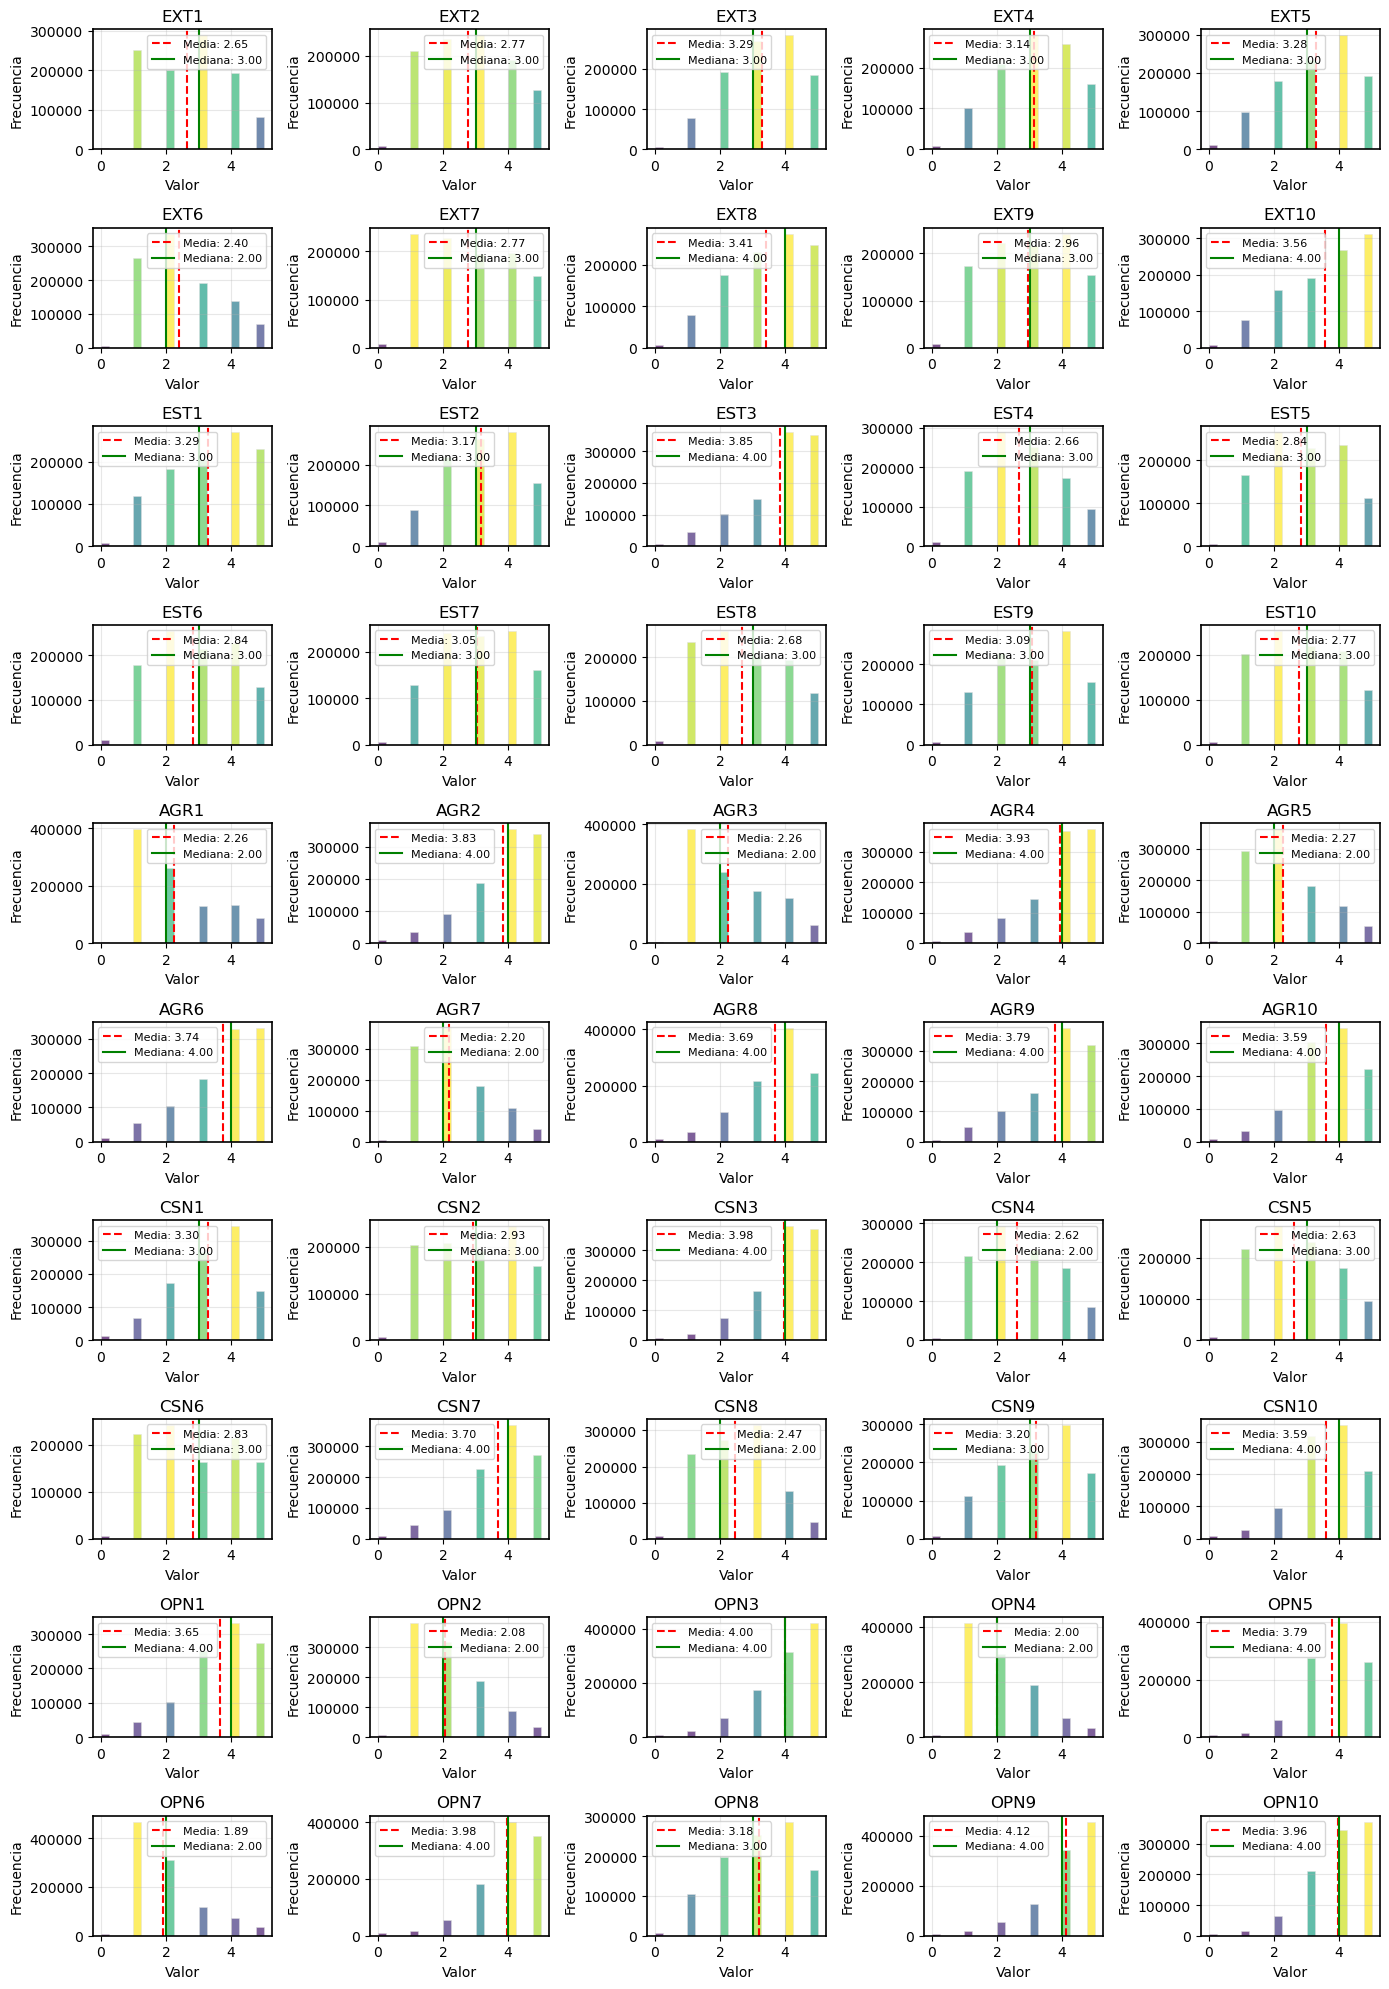

In [40]:
plot_hist(df, df.columns, bins=20, n_cols=5, figsize=(14,20))

### Correlaciones

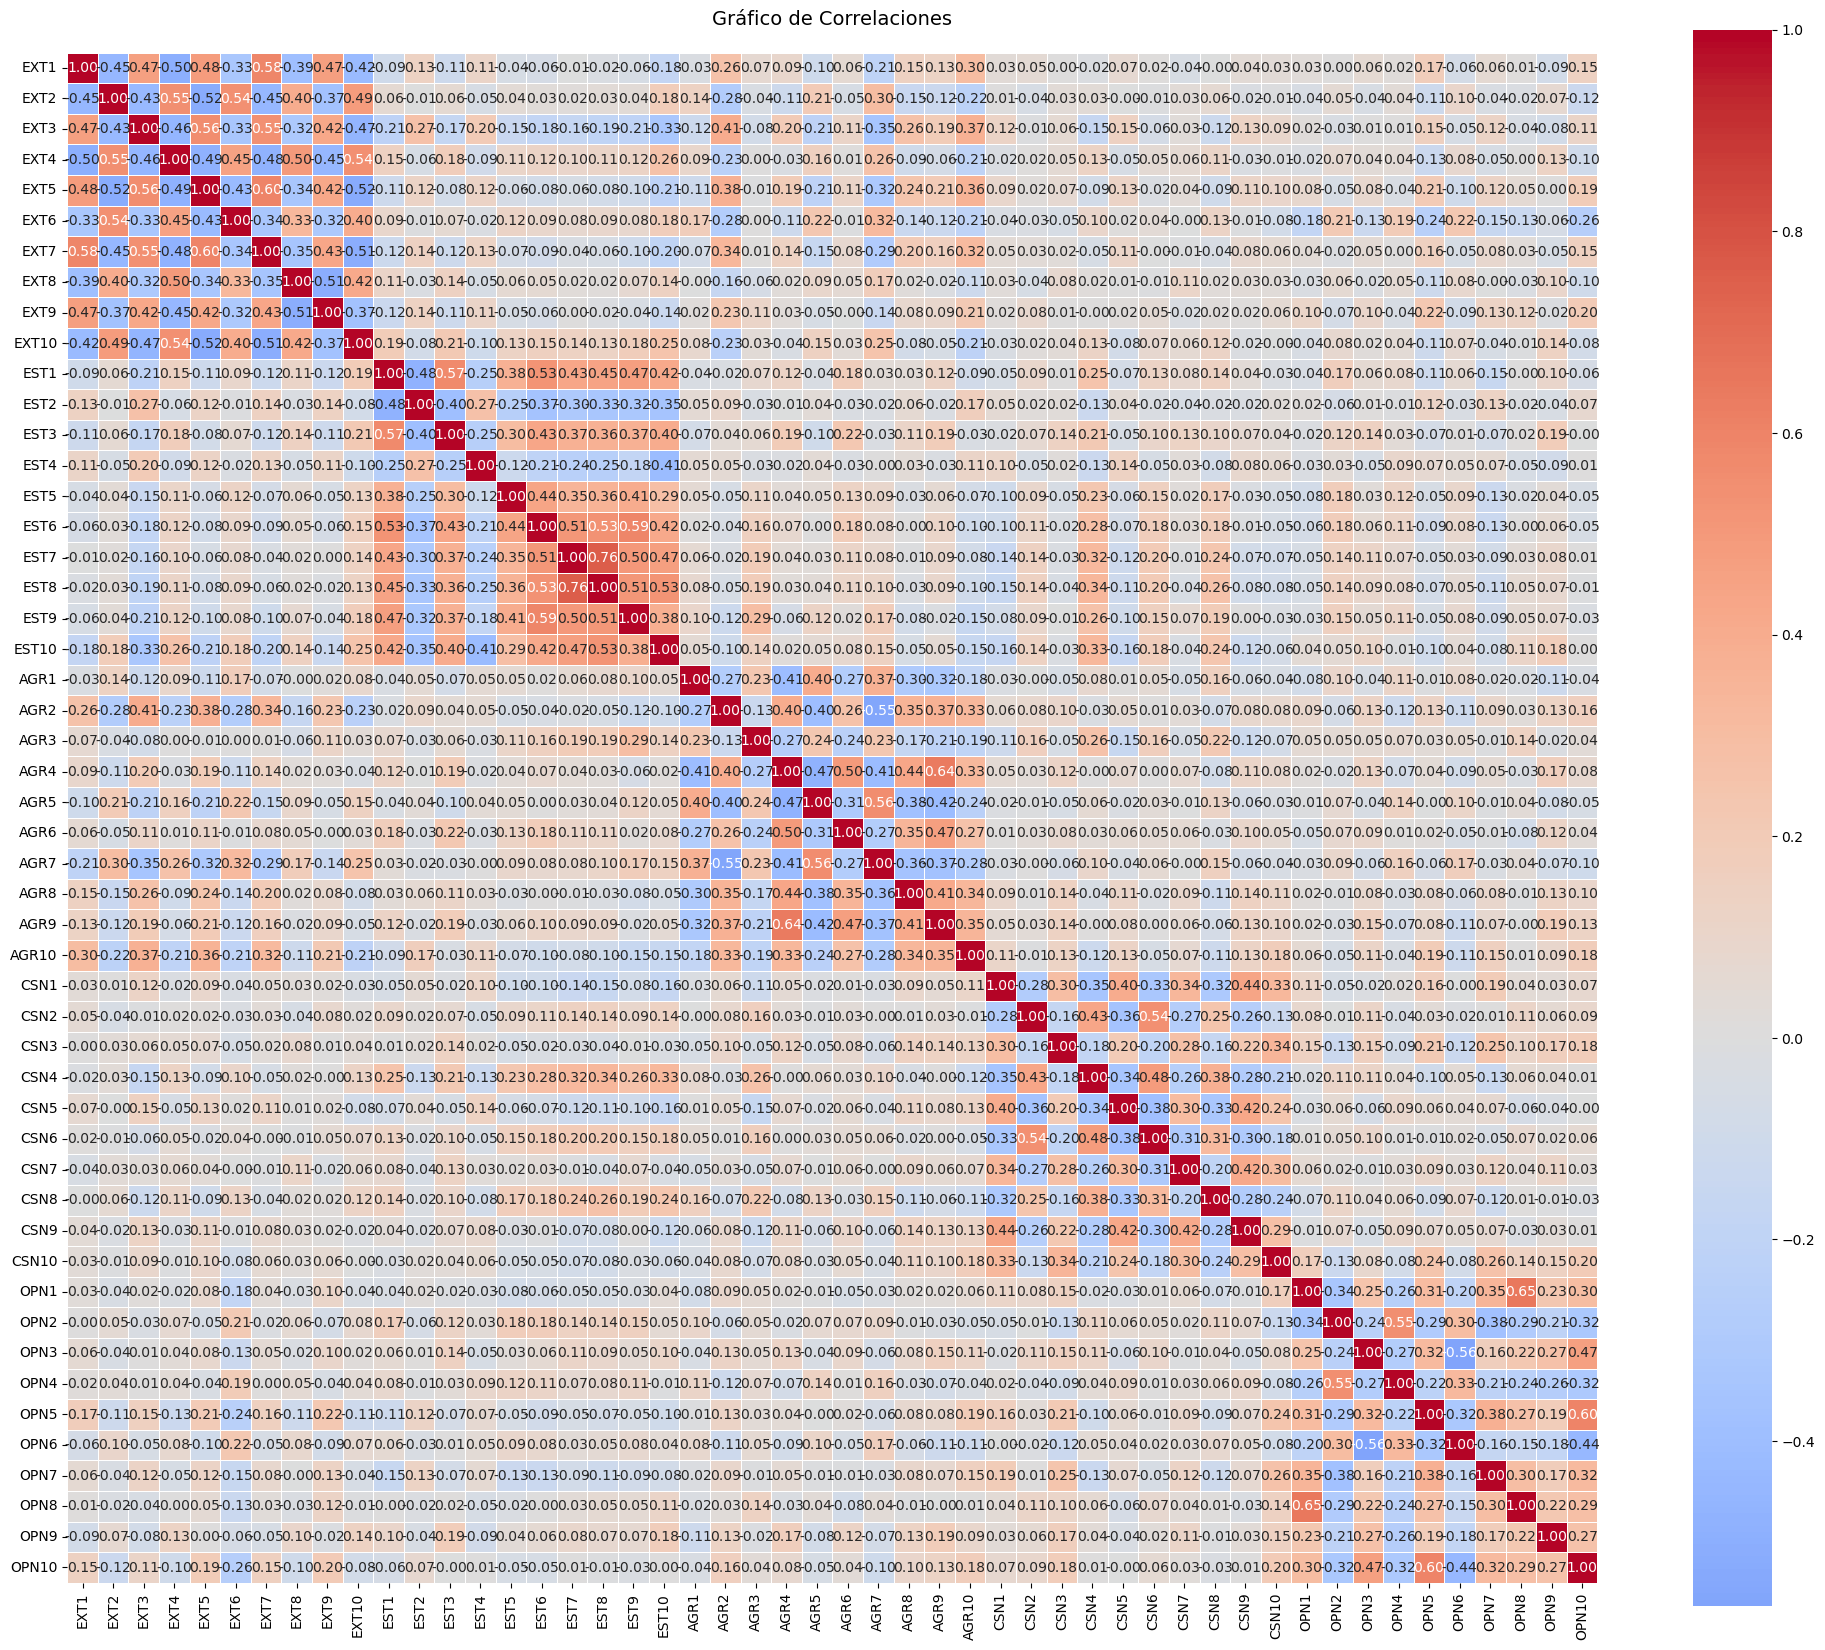

In [74]:
corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0, 
    square=True,
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)
plt.title("Gráfico de Correlaciones", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### Outliers

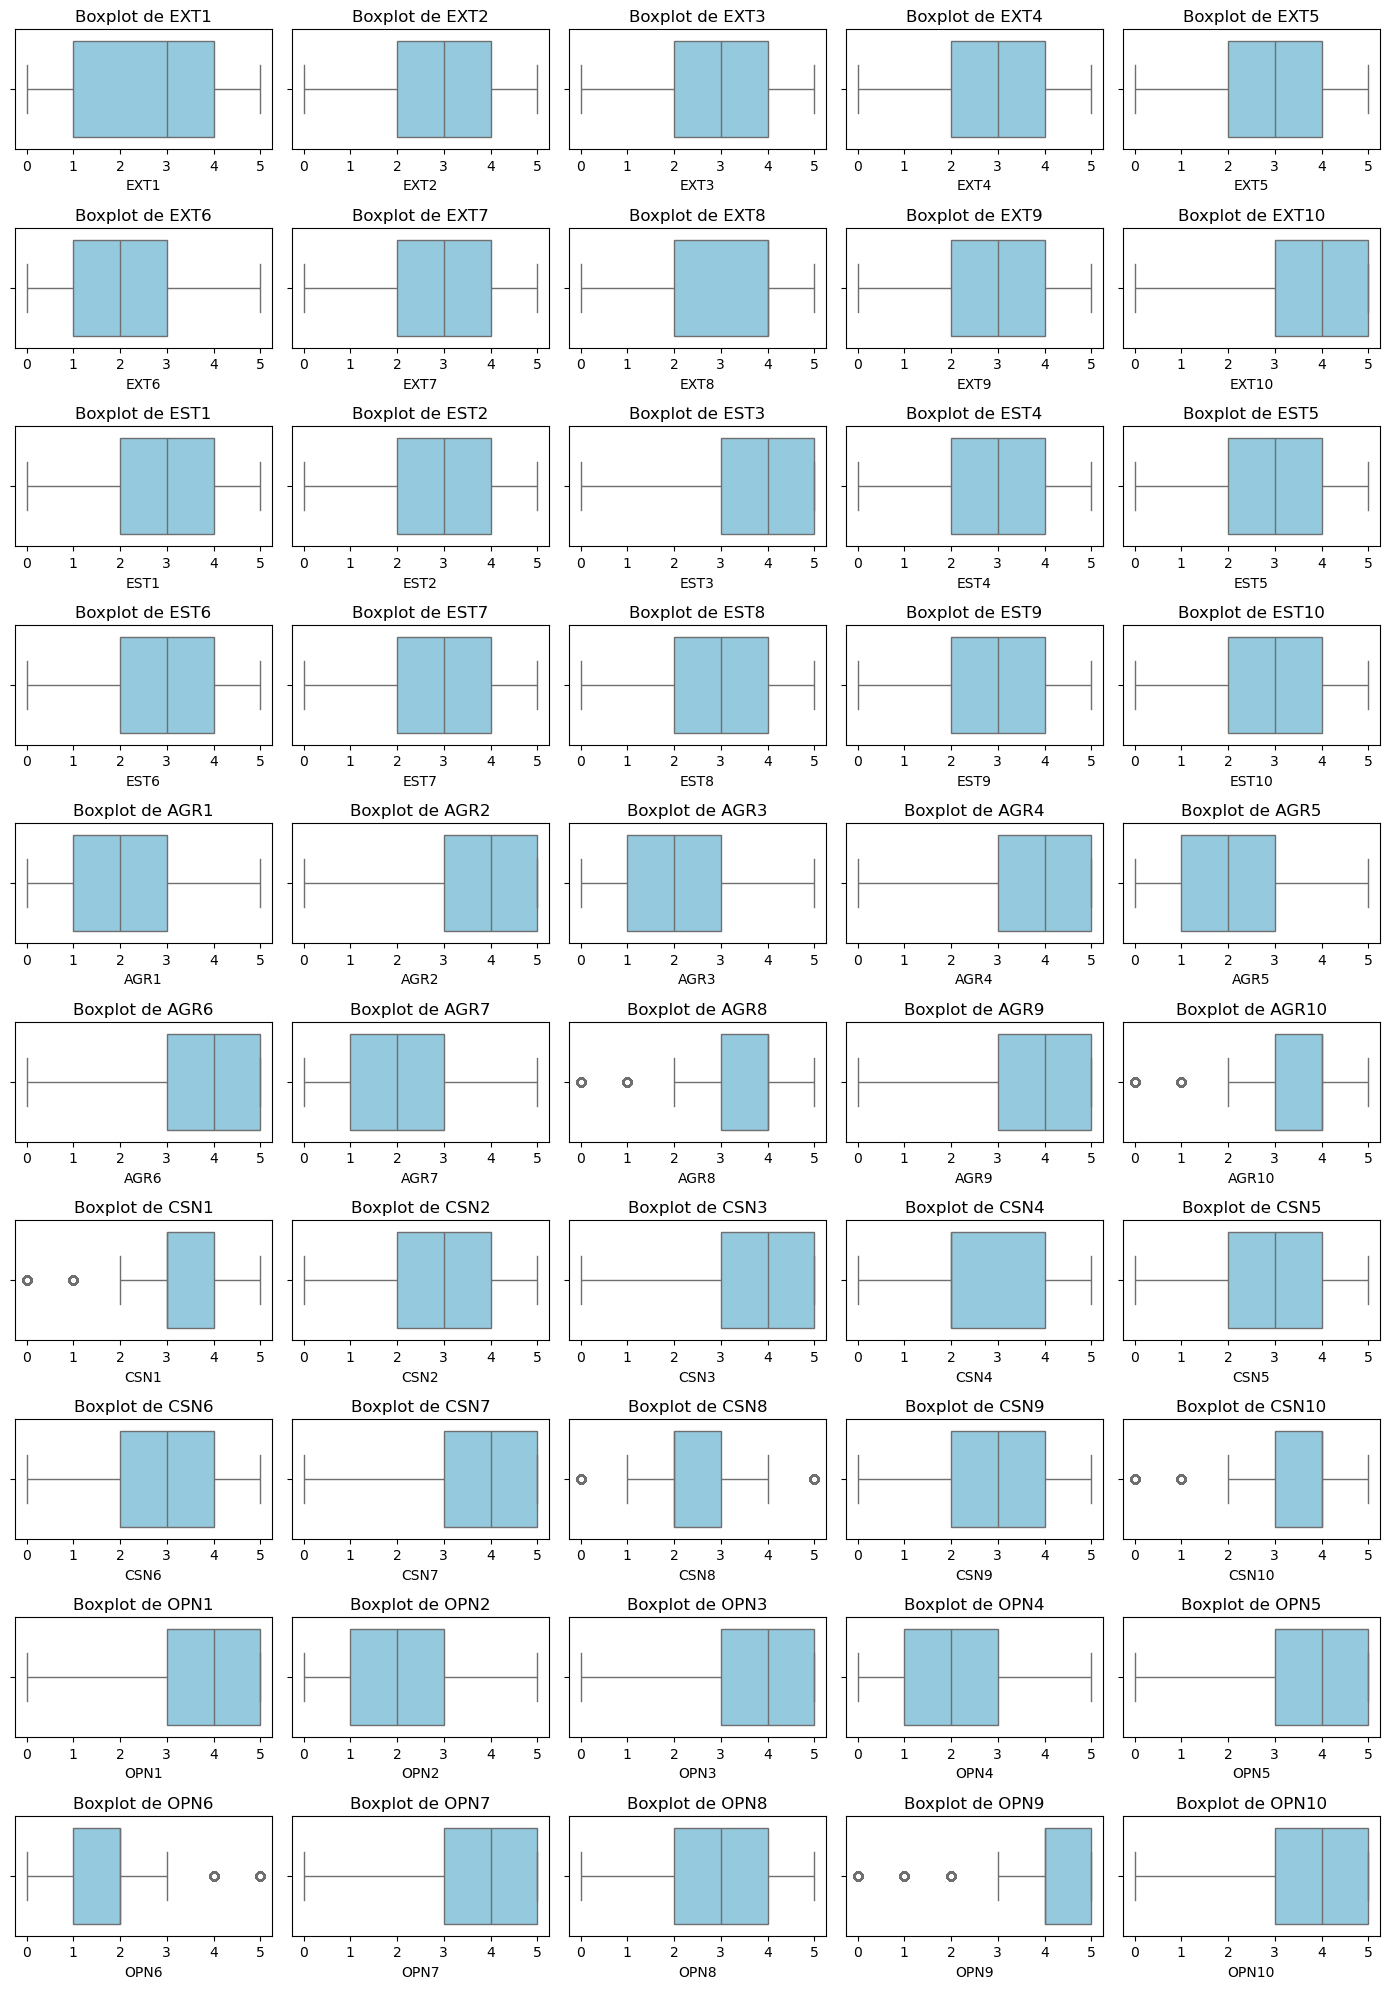

Variable  Outliers_IQR  Outliers_ZScore
0      EXT1             0                0
1      EXT2             0                0
2      EXT3             0                0
3      EXT4             0                0
4      EXT5             0                0
5      EXT6             0                0
6      EXT7             0                0
7      EXT8             0               12
8      EXT9             0                0
9     EXT10             0                0
10     EST1             0                0
11     EST2             0                0
12     EST3             0             5508
13     EST4             0                0
14     EST5             0                0
15     EST6             0                0
16     EST7            12                0
17     EST8             0                0
18     EST9             0                0
19    EST10             0                0
20     AGR1             0                0
21     AGR2             0             9281
22     AGR3             0                0
23     AGR4             0             7636
24     AGR5             0                0
25     AGR6             0            10359
26     AGR7             0                0
27     AGR8         41495             8526
28     AGR9             0             6058
29    AGR10         41855             8403
30     CSN1         79196                0
31     CSN2             0                0
32     CSN3             0             6059
33     CSN4             0                0
34     CSN5             0                0
35     CSN6             0                0
36     CSN7             0             7294
37     CSN8         55254                0
38     CSN9             0                0
39    CSN10         35680             8697
40     OPN1             0             9201
41     OPN2             0                0
42     OPN3             0             7588
43     OPN4             0                0
44     OPN5             0             7682
45     OPN6        110598                0
46     OPN7             0             8468
47     OPN8             0                0
48     OPN9         84322             7692
49    OPN10             0             6177

In [42]:
detect_outliers_summary(df, n_cols=5, threshold=3, figsize=(14,20))

## Preprocesamiento de los Datos

### Separación de los Datos

In [72]:
X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)

### Escalado de Variables

las variables se encuentran en escala de Likert por lo que no es necesario usar una técnica de escalamiento.

## Modelamiento

### Supuestos del Modelo

#### Adecuación Muestral (KMO)

In [47]:
kmo_all, kmo_model = calculate_kmo(df)

print("KMO por variable:\n", kmo_all)
print("\nKMO global:", kmo_model)

KMO por variable:
 [0.93744174 0.9284198  0.95489079 0.94074251 0.950199   0.93108882
 0.93509564 0.90387787 0.91987435 0.9475334  0.91875463 0.89542108
 0.9168584  0.88765975 0.95317162 0.9320952  0.87072161 0.86467478
 0.92367577 0.93437209 0.9150619  0.92977343 0.8897119  0.8894201
 0.90586866 0.91733144 0.89957157 0.94964127 0.90064858 0.95611266
 0.91678454 0.85674313 0.91096516 0.92928981 0.90574631 0.87390508
 0.89299664 0.93148661 0.89097195 0.91922624 0.78249031 0.8321687
 0.8226079  0.81081075 0.87572853 0.79172416 0.90548512 0.76842204
 0.921712   0.86807671]

KMO global: 0.9063017502296873


#### Esfericidad de Barlett

In [49]:
chi_square_value, p_value = calculate_bartlett_sphericity(df)

print("Chi-cuadrado:", chi_square_value)
print("p-valor:", p_value)

Chi-cuadrado: 18991816.652092073
p-valor: 0.0


#### Fiabilidad Interna (Alfa de Cronbach)

In [55]:
alpha, ci = pg.cronbach_alpha(df)

print("Alfa de Cronbach:", alpha)
print("IC 95%:", ci)

Alfa de Cronbach: 0.6943535047934059
IC 95%: [0.694 0.695]


#### Correlaciones y determinante

In [75]:
det_corr = np.linalg.det(corr_matrix)

print("Determinante de la matriz de correlación:", det_corr)
if det_corr > 0.00001:
    print("Adecuado para Análisis Factorial (no hay multicolinealidad extrema).")
else:
    print("Problema: posible multicolinealidad extrema. Revisa variables.")

Determinante de la matriz de correlación: 4.590489573215767e-09
Problema: posible multicolinealidad extrema. Revisa variables.


#### Métricas Adicionales

##### Anti-image matrix

In [76]:
R_inv = inv(corr_matrix)
n = R_inv.shape[0]
A = np.zeros_like(R_inv)
for i in range(n):
    for j in range(n):
        if i == j:
            A[i, j] = 1 - 1 / R_inv[i, i]
        else:
            A[i, j] = -R_inv[i, j] / np.sqrt(R_inv[i, i] * R_inv[j, j])

anti_image_matrix = pd.DataFrame(A, index=df.columns, columns=df.columns)
msa_values = np.diag(anti_image_matrix)
msa_df = pd.DataFrame({"Variable": df.columns, "MSA": msa_values})
for var, val in zip(df.columns, msa_values):
    if val >= 0.50:
        print(f"{var}: MSA = {val:.3f} → Aceptable")
    else:
        print(f"{var}: MSA = {val:.3f} → No recomendable incluir")

EXT1: MSA = 0.472 → No recomendable incluir
EXT2: MSA = 0.498 → No recomendable incluir
EXT3: MSA = 0.520 → Aceptable
EXT4: MSA = 0.523 → Aceptable
EXT5: MSA = 0.539 → Aceptable
EXT6: MSA = 0.428 → No recomendable incluir
EXT7: MSA = 0.531 → Aceptable
EXT8: MSA = 0.399 → No recomendable incluir
EXT9: MSA = 0.434 → No recomendable incluir
EXT10: MSA = 0.472 → No recomendable incluir
EST1: MSA = 0.509 → Aceptable
EST2: MSA = 0.366 → No recomendable incluir
EST3: MSA = 0.452 → No recomendable incluir
EST4: MSA = 0.224 → No recomendable incluir
EST5: MSA = 0.278 → No recomendable incluir
EST6: MSA = 0.510 → Aceptable
EST7: MSA = 0.611 → Aceptable
EST8: MSA = 0.644 → Aceptable
EST9: MSA = 0.489 → No recomendable incluir
EST10: MSA = 0.480 → No recomendable incluir
AGR1: MSA = 0.288 → No recomendable incluir
AGR2: MSA = 0.432 → No recomendable incluir
AGR3: MSA = 0.274 → No recomendable incluir
AGR4: MSA = 0.544 → Aceptable
AGR5: MSA = 0.432 → No recomendable incluir
AGR6: MSA = 0.365 → No r

##### Comunalidades

In [60]:
fa = FactorAnalyzer(n_factors=5, rotation=None)
fa.fit(df)

communalities = fa.get_communalities()
print("Comunalidades iniciales por ítem:")
print(communalities)

Comunalidades iniciales por ítem:
[0.48434332 0.47695013 0.51542839 0.53354703 0.55175668 0.34395329
 0.53000084 0.34463551 0.42187639 0.4699507  0.48704905 0.20217764
 0.43287596 0.11683675 0.29050274 0.53661118 0.538772   0.5673055
 0.51822303 0.46286301 0.22858291 0.40123083 0.26447273 0.60126622
 0.42283822 0.37914115 0.47070961 0.34681797 0.5173393  0.29557683
 0.40186777 0.30896363 0.26607797 0.42905631 0.40997399 0.3563204
 0.34165316 0.25571498 0.41095829 0.29892194 0.34476769 0.31535815
 0.33313865 0.24281817 0.42529846 0.20397294 0.3086331  0.3312081
 0.25998105 0.49474286]


##### Mardia Test

In [63]:
sample_df = df.sample(n=10000, random_state=42)

mardia_test = pg.multivariate_normality(sample_df, alpha=0.05)
print(mardia_test)

HZResults(hz=np.float64(1.0298524542863623), pval=np.float64(0.0), normal=False)


### Número de Factores

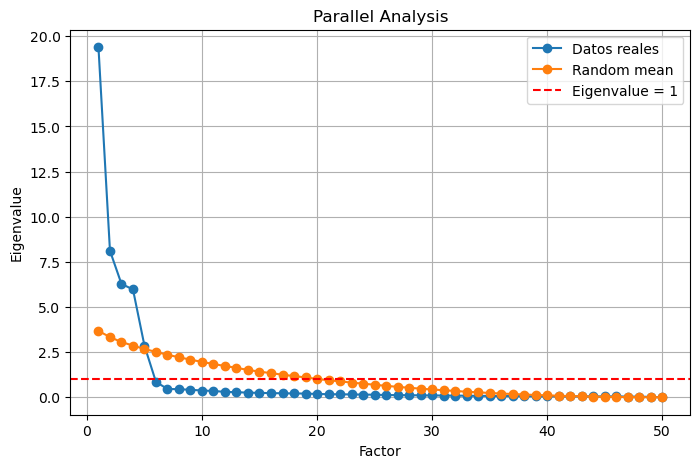

In [112]:
corr_spearman = X_train.corr(method='spearman')
ev_real, ev_rand_mean = parallel_analysis(corr_spearman, n_iter=100)

plt.figure(figsize=(8,5))
plt.plot(range(1,len(ev_real)+1), ev_real, marker='o', label='Datos reales')
plt.plot(range(1,len(ev_real)+1), ev_rand_mean, marker='o', label='Random mean')
plt.axhline(1, color='red', linestyle='--', label='Eigenvalue = 1')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Parallel Analysis')
plt.legend()
plt.grid()
plt.show()

### Selección de Rotación

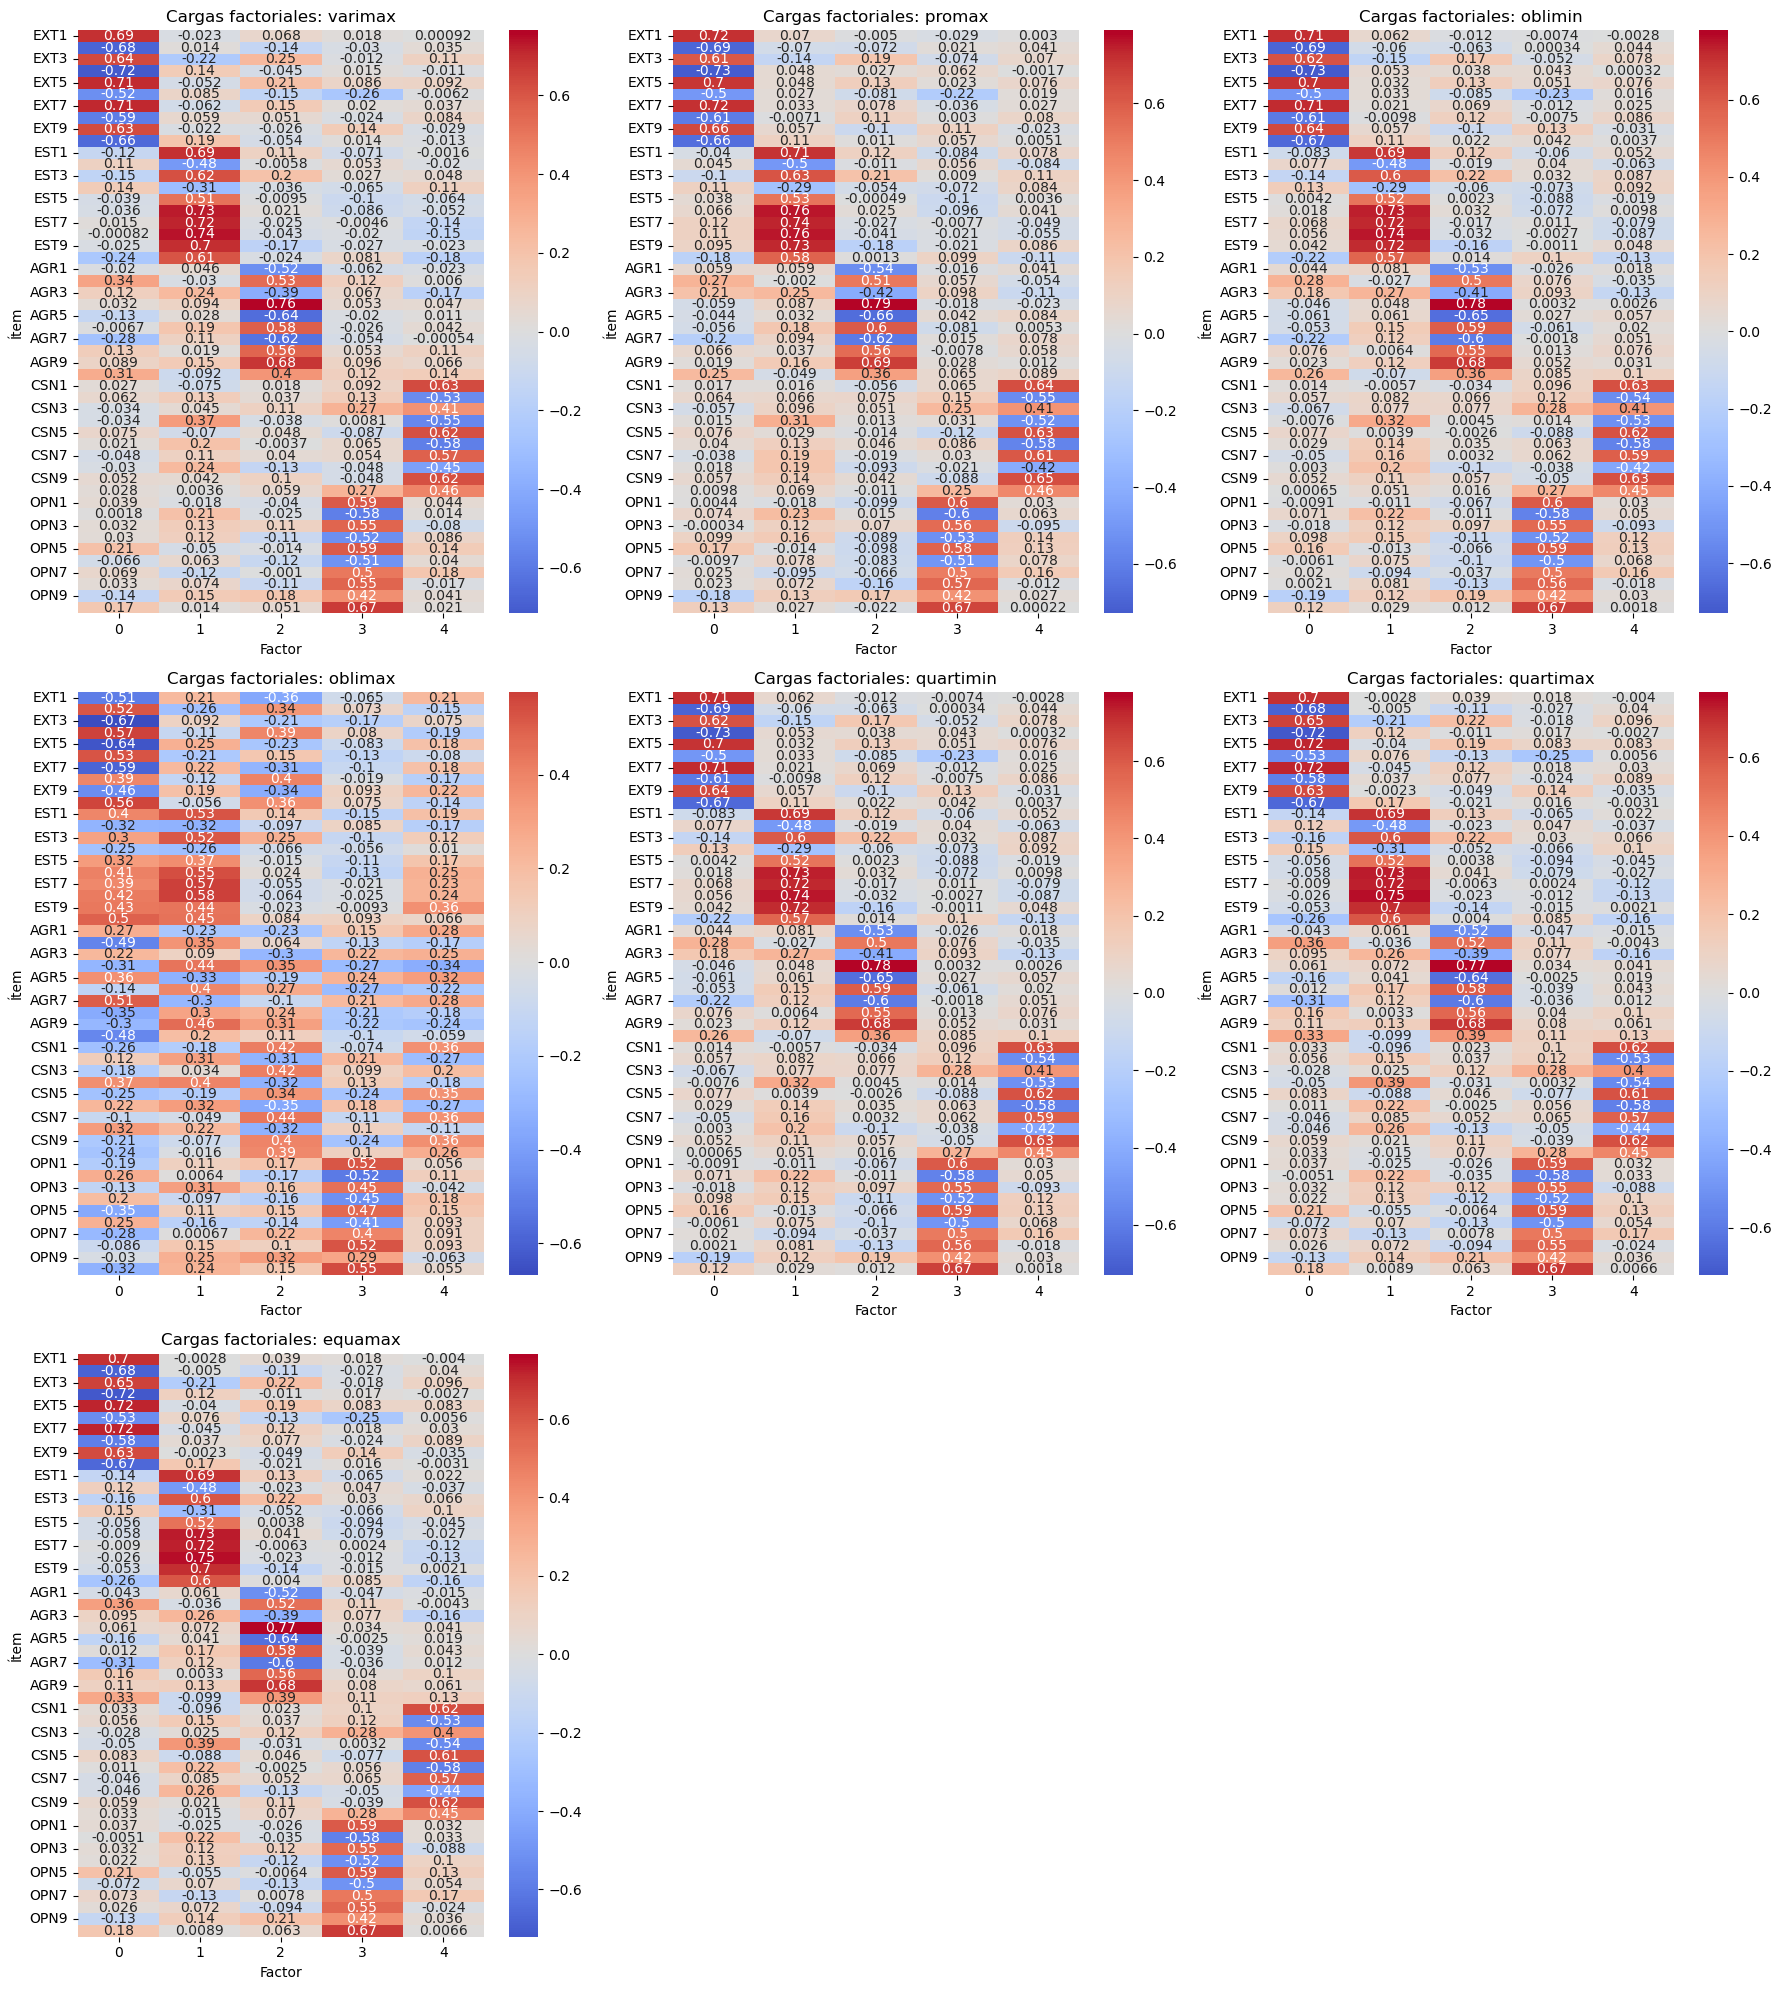

In [110]:
plot_factor_loadings_corr(corr_spearman, n_factors=5, figsize=(18, 20))

### Ejecución del Modelo

In [134]:
fa = FactorAnalyzer(n_factors=5, rotation='promax', is_corr_matrix=True)
fa.fit(corr_matrix)
X_train_trans = fa.transform(X_train)

C:\anaconda3\Lib\site-packages\factor_analyzer\factor_analyzer.py:766: UserWarning: Could not find original mean and standard deviation; usingthe mean and standard deviation from the current data set.
  warnings.warn(


### Análisis Confirmatorio

In [132]:
desc = """
F1 =~ EXT1 + EXT2 + EXT3 + EXT4 + EXT5 + EXT6 + EXT7 + EXT8 + EXT9 + EXT10
F2 =~ EST1 + EST2 + EST3 + EST4 + EST5 + EST6 + EST7 + EST8 + EST9 + EST10
F3 =~ AGR1 + AGR2 + AGR3 + AGR4 + AGR5 + AGR6 + AGR7 + AGR8 + AGR9 + AGR10
F4 =~ OPN1 + OPN2 + OPN3 + OPN4 + OPN5 + OPN6 + OPN7 + OPN8 + OPN9 + OPN10
F5 =~ CSN1 + CSN2 + CSN3 + CSN4 + CSN5 + CSN6 + CSN7 + CSN8 + CSN9 + CSN10
"""

model = Model(desc)
model.fit(X_test)
print(inspect(model))

stats = semopy.calc_stats(model)
print(stats)

     lval  op  rval  Estimate  Std. Err     z-value p-value
0    EXT1   ~    F1  1.000000         -           -       -
1    EXT2   ~    F1 -1.062730  0.003429 -309.953785     0.0
2    EXT3   ~    F1  0.952401  0.003135  303.788298     0.0
3    EXT4   ~    F1 -1.030656  0.003221 -320.012686     0.0
4    EXT5   ~    F1  1.084532  0.003328  325.902291     0.0
..    ...  ..   ...       ...       ...         ...     ...
110  OPN5  ~~  OPN5  0.570155  0.001918  297.307217     0.0
111  OPN6  ~~  OPN6  0.938058  0.002825  332.009505     0.0
112  OPN7  ~~  OPN7  0.777605  0.002352  330.554743     0.0
113  OPN8  ~~  OPN8  1.159719  0.003545  327.170964     0.0
114  OPN9  ~~  OPN9  0.927639  0.002708  342.613587     0.0

[115 rows x 7 columns]
        DoF  DoF Baseline          chi2  chi2 p-value  chi2 Baseline      CFI  \
Value  1165          1225  1.361075e+06           0.0   4.746693e+06  0.71343   

            GFI     AGFI       NFI       TLI     RMSEA         AIC  \
Value  0.713258  0.6984

## Visualización

### Cargas

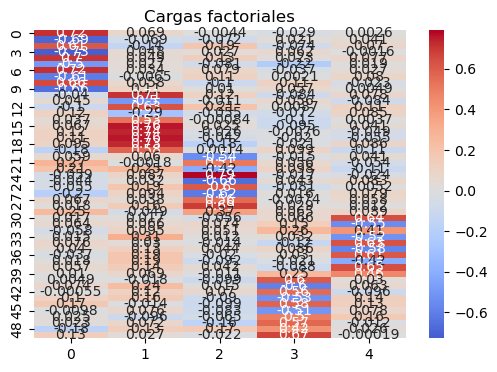

In [133]:
loadings = fa.loadings_
plt.figure(figsize=(6,4))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Cargas factoriales")
plt.show()

### Correlación Entre Factores

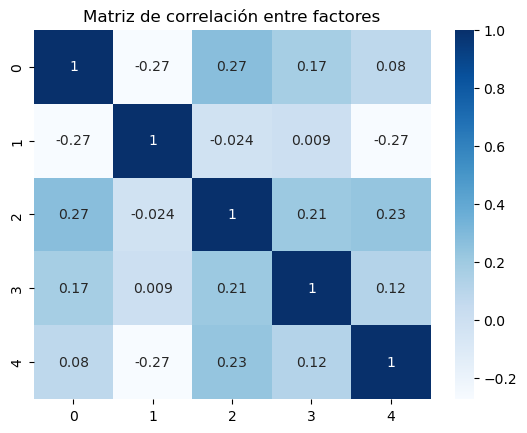

In [138]:
factor_corr = pd.DataFrame(X_train_trans).corr()
sns.heatmap(factor_corr, annot=True, cmap="Blues")
plt.title("Matriz de correlación entre factores")
plt.show()

### Relación Factores - Variables

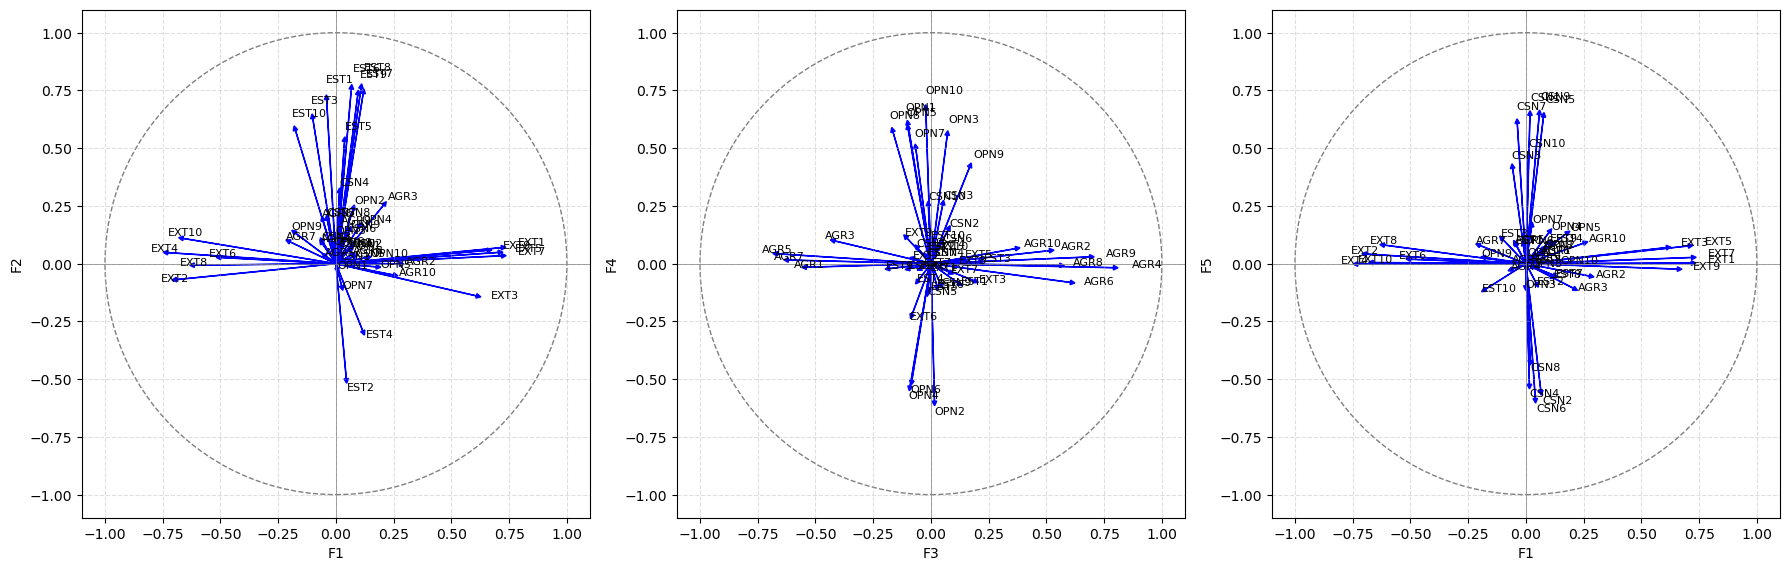

In [162]:
var_names = X_train.columns.tolist()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_correlation_circle(axes[0], loadings, 0, 1, var_names=var_names)
plot_correlation_circle(axes[1], loadings, 2, 3, var_names=var_names)
plot_correlation_circle(axes[2], loadings, 0, 4, var_names=var_names)

plt.tight_layout()
plt.show()

### Comunalidades

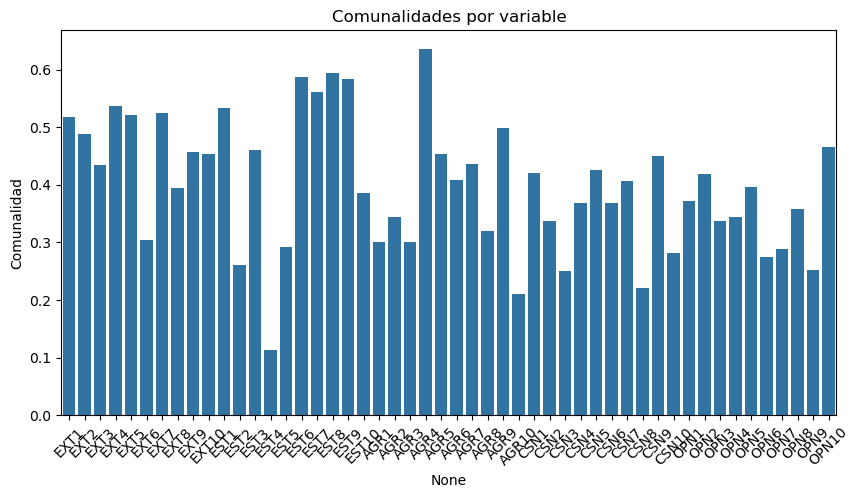

In [146]:
communalities = fa.get_communalities()

plt.figure(figsize=(10,5))
sns.barplot(x=df.columns, y=communalities)
plt.xticks(rotation=45)
plt.title("Comunalidades por variable")
plt.ylabel("Comunalidad")
plt.show()